## Praktikum 1

In [1]:
# Install ANNOY
!pip install annoy

     ---------------------------------------- 0.0/647.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/647.5 kB ? eta -:--:--
     ---------------- ----------------------- 262.1/647.5 kB ? eta -:--:--
     ------------------------------ ------- 524.3/647.5 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 647.5/647.5 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for annoy: filename=annoy-1.17.3-cp313-cp313-win_amd64.whl size=53405 sha256=008bc00d91e6f378f4af8ac03a0a0e210cea4c48a484dab01c9c2abe60d53bbb
  Stored in directory: c:\users\innam\appdata\local\pip\cache\wheels\fc\4e\87\f1f957e7382aa370452cff98276f51686924d5415e449800ed
Successfully built annoy


  DEPRECATION: Building 'annoy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'annoy'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [1]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

In [2]:
# Build Random Dataset and Query Point
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # random value at 100x100 space

# Query point (pick 1 random data point)
query = X[np.random.randint(0, n_points)]

In [3]:
# Compute Exact NN Using Brute Force
# It will visit the data one by one
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 0.8519 ms


In [4]:
# ANNOY 3 Tree
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # find 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")


Annoy NN index: [219, 898, 593]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.2793154441691197)]
Waktu Annoy: 0.2012 ms


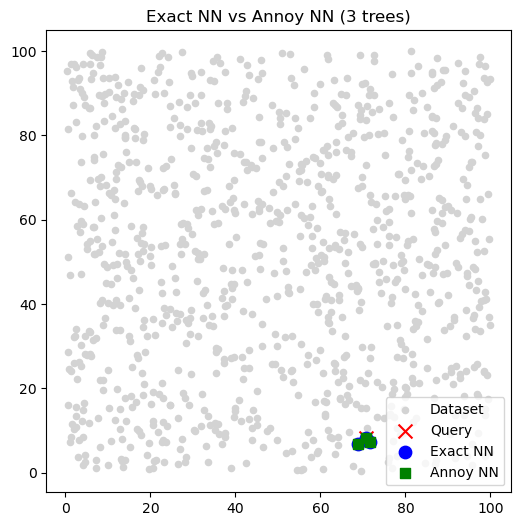

In [5]:
# Visualize
# Knowing the NN produced by Exact NN and ANNOY
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

## Praktikum 2

In [13]:
!pip install faiss-cpu

   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
    --------------------------------------- 0.3/18.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.2 MB 1.2 MB/s eta 0:00:15
   - -------------------------------------- 0.5/18.2 MB 1.2 MB/s eta 0:00:15
   -- ------------------------------------- 1.0/18.2 MB 1.3 MB/s eta 0:00:14
   -- ------------------------------------- 1.3/18.2 MB 1.2 MB/s eta 0:00:14
   --- ------------------------------------ 1.6/18.2 MB 1.4 MB/s eta 0:00:13
   ---- ----------------------------------- 1.8/18.2 MB 1.2 MB/s eta 0:00:14
   ------ --------------------------------- 2.9/18.2 MB 1.7 MB/s eta 0:00:10
   ------ --------------------------------- 3.1/18.2 MB 1.7 MB/s eta 0:00:10
   ------- -----------------------

In [6]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

In [7]:
# Build random data
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 data 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query point

In [8]:
# Search NN using Exact NN
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

# Compute Exact NN Time
start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # Find 3 NN
end = time.time()
time_flat = end - start

In [10]:
# Compute FAISS
nlist = 10   # n-cluster (inverted list)
m = 2        # number of subvector
quantizer = faiss.IndexFlatL2(2)   # used by IVF for initiatl cluster
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

In [11]:
# Print The Peformances
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.00035190582275390625
Waktu IVF+PQ: 0.00020599365234375


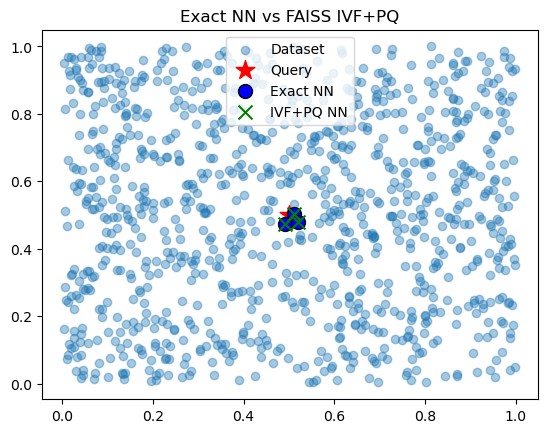

In [12]:
# Visualize
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Flat NN -> Exact NN
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# IVF+PQ NN -> FAISS
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Exact NN vs FAISS IVF+PQ")
plt.show()

## Praktikum 3

In [13]:
!pip install hnswlib

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp313-cp313-win_amd64.whl size=156640 sha256=e4d31b8d7898d9e9404ab4fb6e91e02ba5a465fa7fafe8cb968b5a6af79e8847
  Stored in directory: c:\users\innam\appdata\local\pip\cache\wheels\35\04\88\b31765a4b9957705e18065db4657e61fc8da54f50e3ef0b67e
Successfully built hnswlib


In [14]:
import hnswlib
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

In [15]:
# Build Dummy Dataset
num_elements = 1000
dim = 2
data = np.random.random((num_elements, dim)).astype(np.float32)

# Query point
query = np.array([[0.5, 0.5]], dtype=np.float32)
k = 5  # cari 5 tetangga terdekat

In [16]:
# Build NN Model
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(data)

# Compute time performace
start = time.time()
distances, indices = nn.kneighbors(query)
end = time.time()

print("=== Exact NN ===")
print("Indices:", indices)
print("Distances:", distances)
print("Waktu:", end - start, "s")

=== Exact NN ===
Indices: [[830 247 473 913 592]]
Distances: [[0.00993625 0.01363944 0.01646171 0.03779694 0.03859071]]
Waktu: 0.18874597549438477 s


c:\Users\innam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\innam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\innam\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\innam\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

In [17]:
# Initiate Index
p = hnswlib.Index(space='l2', dim=dim)  

# Define Max Elements
p.init_index(max_elements=num_elements, ef_construction=100, M=16)

# Add Data
p.add_items(data)

# Set searching parameter
p.set_ef(50)   # tradeoff speed vs accuracy

start = time.time()
labels, distances = p.knn_query(query, k=k)
end = time.time()

print("\n=== HNSW ===")
print("Indices:", labels)
print("Distances:", distances)
print("Waktu:", end - start, "s")


=== HNSW ===
Indices: [[830 247 473 913 592]]
Distances: [[9.8728990e-05 1.8603442e-04 2.7098786e-04 1.4286089e-03 1.4892431e-03]]
Waktu: 0.0002989768981933594 s


## Praktikum 4

In [19]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# Build 1mio rows with 5D
# ===============================
n_data = 1_000_000   # try 100_000 if you have limited memory
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")

=== Annoy ===
Build time: 4.264963388442993 detik
Query time: 0.000179290771484375 detik
Neighbors: [473142, 815660, 216089, 418503, 261601] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.0050122737884521484 detik
Query time: 0.0033311843872070312 detik
Neighbors: [473142 815660 216089 418503 261601] ...

=== HNSW (hnswlib) ===
Build time: 16.798469305038452 detik
Query time: 0.00021505355834960938 detik
Neighbors: [473142 815660 216089 418503 261601] ...


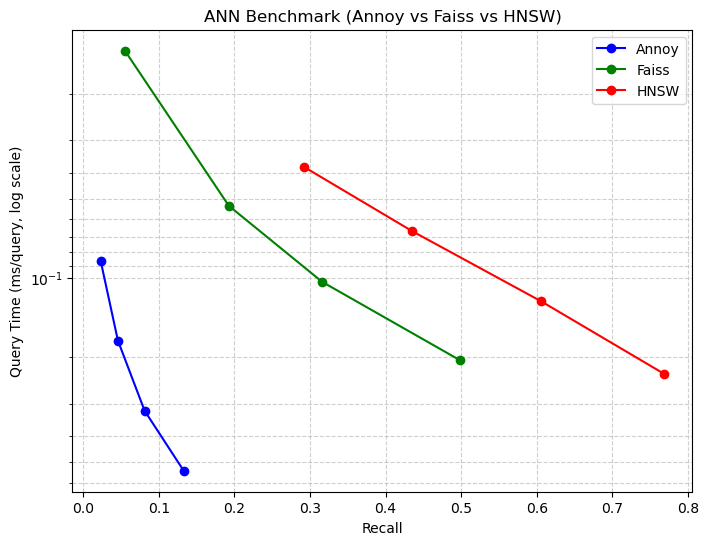

In [21]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

## Tugas 1

In [22]:
def generate_data(n, d):
    return np.random.random((n, d)).astype('float32')

def benchmark_annoy(data, query, n_trees=10):
    f = data.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(data):
        index.add_item(i, v)
    index.build(n_trees)
    start = time.time()
    for q in query:
        index.get_nns_by_vector(q, 10)
    return time.time() - start

def benchmark_faiss(data, query):
    d = data.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(data)
    start = time.time()
    index.search(query, 10)
    return time.time() - start

def benchmark_hnsw(data, query, ef=200, M=16):
    d = data.shape[1]
    num_elements = data.shape[0]
    index = hnswlib.Index(space='l2', dim=d)
    index.init_index(max_elements=num_elements, ef_construction=200, M=M)
    index.add_items(data)
    index.set_ef(ef)
    start = time.time()
    index.knn_query(query, k=10)
    return time.time() - start

for (n, d) in [(1000, 2), (1000, 5), (1000000, 2), (1000000, 5)]:
    data = generate_data(n, d)
    query = data[:100]  # ambil 100 query
    t_annoy = benchmark_annoy(data, query)
    t_faiss = benchmark_faiss(data, query)
    t_hnsw = benchmark_hnsw(data, query)
    print(f"{n}/{d}D -> Annoy: {t_annoy:.4f}s, Faiss: {t_faiss:.4f}s, HNSW: {t_hnsw:.4f}s")

1000/2D -> Annoy: 0.0023s, Faiss: 0.0010s, HNSW: 0.0021s
1000/5D -> Annoy: 0.0018s, Faiss: 0.0005s, HNSW: 0.0020s
1000000/2D -> Annoy: 0.0049s, Faiss: 0.0743s, HNSW: 0.0021s
1000000/5D -> Annoy: 0.0048s, Faiss: 0.0924s, HNSW: 0.0031s


## Tugas 2

Read dataset

In [23]:
import pandas as pd

df =pd.read_csv('dataset/spotify_songs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955320 entries, 0 to 955319
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                955320 non-null  object 
 1   name              955309 non-null  object 
 2   album_name        385557 non-null  object 
 3   artists           955318 non-null  object 
 4   danceability      955320 non-null  float64
 5   energy            955320 non-null  float64
 6   key               955320 non-null  object 
 7   loudness          955320 non-null  float64
 8   mode              955320 non-null  object 
 9   speechiness       955320 non-null  float64
 10  acousticness      955320 non-null  float64
 11  instrumentalness  955320 non-null  float64
 12  liveness          955320 non-null  float64
 13  valence           955320 non-null  float64
 14  tempo             955320 non-null  float64
 15  duration_ms       955320 non-null  float64
 16  lyrics            95

Pemilihan fitur dan normalisasi

In [24]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = df[features].values

# Standarisasi fitur
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

Pencarian track dengan exact nearest neighbor

In [54]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

n_samples, dim = X_scaled.shape
n_queries = 100  # jumlah query untuk evaluasi
np.random.seed(42)
query_ids = np.random.choice(range(n_samples), size=3, replace=False)
queries = X_scaled[query_ids]

exact_nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
exact_nn.fit(X_scaled)
gt_indices = exact_nn.kneighbors(queries, return_distance=False)
gt_neighbors = [exact_nn.kneighbors([X_scaled[q]], return_distance=False)[0] for q in query_ids]

results = []

Pencarian track dengan annoy

In [48]:
f = dim
annoy_index = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    annoy_index.add_item(i, v)
annoy_index.build(10)

start = time.time()
annoy_neighbors = [annoy_index.get_nns_by_vector(q, k) for q in queries]
end = time.time()

recall_annoy = np.mean([len(set(gt) & set(ann)) / k 
                        for gt, ann in zip(gt_indices, annoy_neighbors)])
annoy_neighbors_vis = [annoy_index.get_nns_by_vector(X_scaled[q], k) for q in query_ids]

results.append(("Annoy", recall_annoy, end-start))

Pencarian track dengan faiss

In [49]:
index_faiss = faiss.IndexFlatL2(dim)
index_faiss.add(X_scaled.astype(np.float32))

start = time.time()
_, faiss_neighbors = index_faiss.search(queries.astype(np.float32), k)
end = time.time()

recall_faiss = np.mean([len(set(gt) & set(fn)) / k 
                        for gt, fn in zip(gt_indices, faiss_neighbors)])
faiss_neighbors_vis = index_faiss.search(X_scaled[query_ids].astype(np.float32), k)

results.append(("Faiss", recall_faiss, end-start))

Pencarian track dengan hnsw

In [50]:
p = hnswlib.Index(space='l2', dim=dim)
p.init_index(max_elements=n_samples, ef_construction=200, M=16)
p.add_items(X_scaled)

start = time.time()
hnsw_neighbors, _ = p.knn_query(queries, k=k)
end = time.time()

recall_hnsw = np.mean([len(set(gt) & set(hn)) / k 
                       for gt, hn in zip(gt_indices, hnsw_neighbors)])
hnsw_neighbors_vis, _ = p.knn_query(X_scaled[query_ids], k=k)
results.append(("HNSW", recall_hnsw, end-start))

Perbandingan

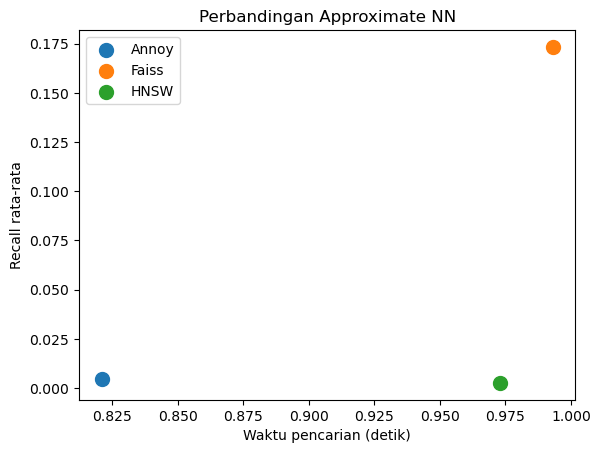

In [44]:
for method, recall, timing in results:
    plt.scatter(recall, timing, label=method, s=100)

plt.xlabel("Waktu pencarian (detik)")
plt.ylabel("Recall rata-rata")
plt.title("Perbandingan Approximate NN")
plt.legend()
plt.show()

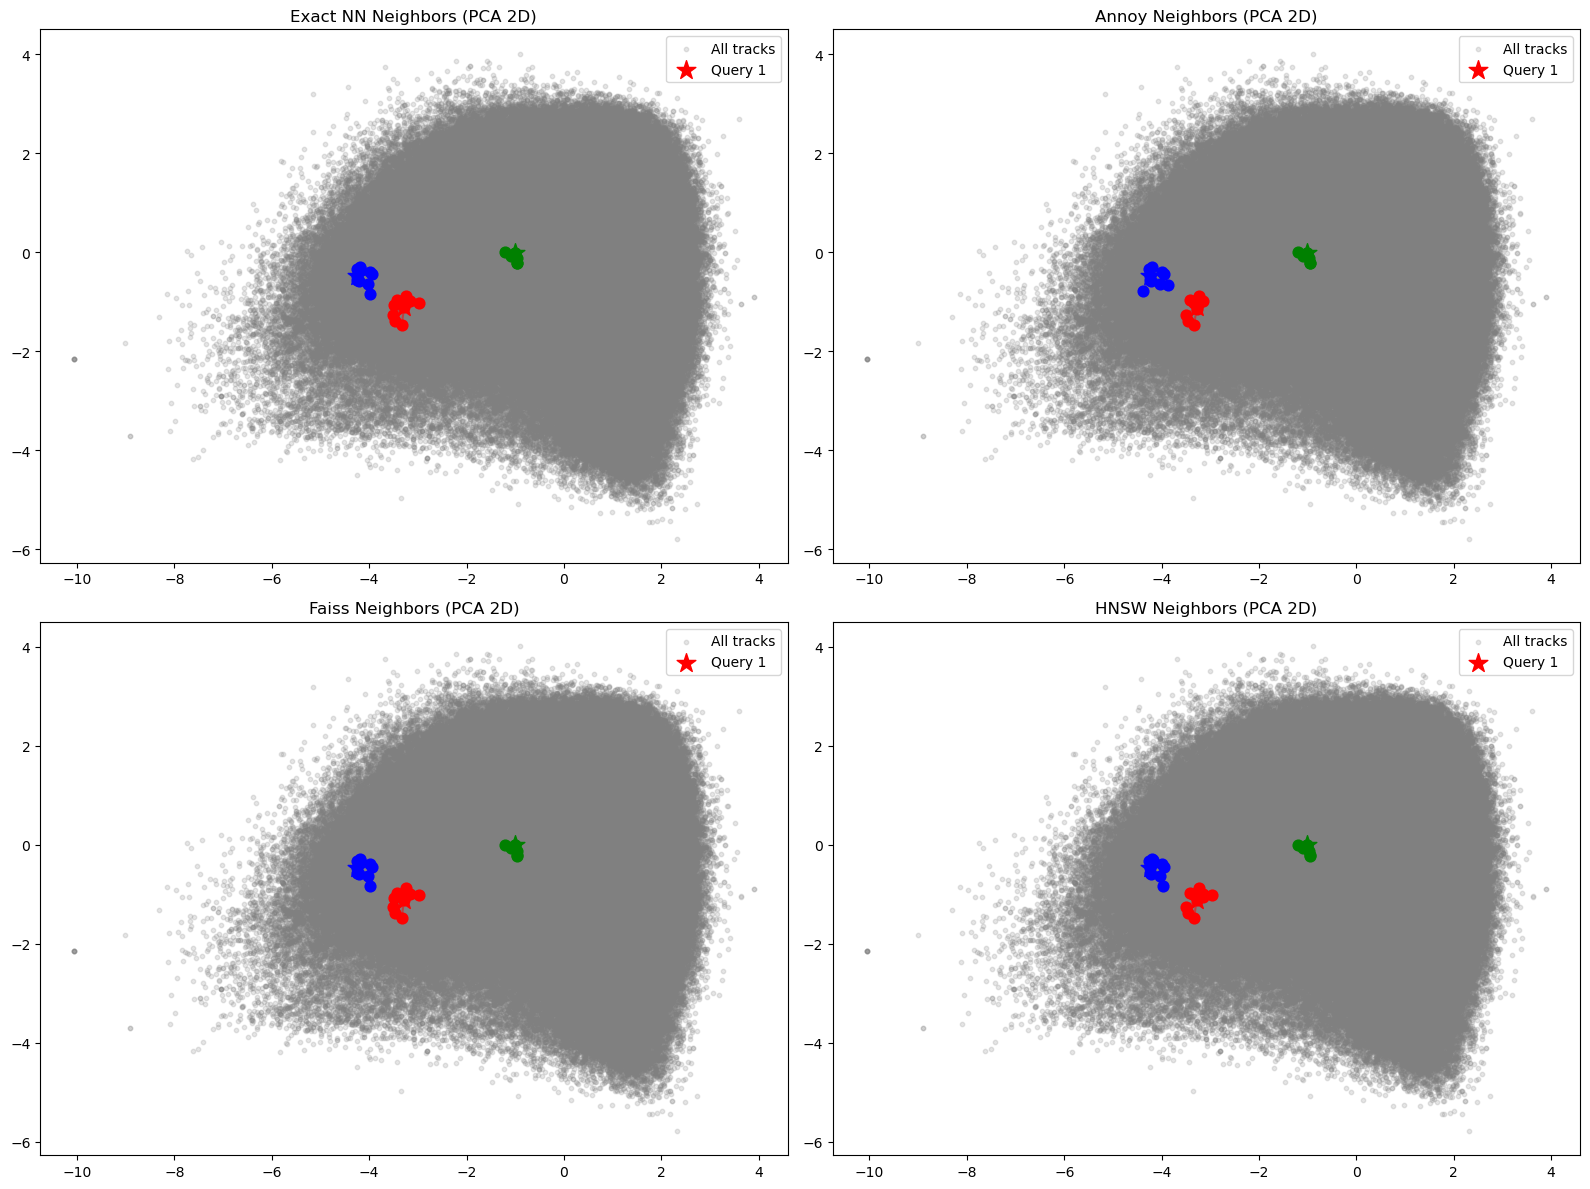

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduksi dimensi
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

methods_vis = {
    "Exact NN": [[int(n) for n in neigh] for neigh in gt_neighbors],
    "Annoy": [[int(n) for n in neigh] for neigh in annoy_neighbors],
    "Faiss": [[int(n) for n in neigh] for neigh in faiss_neighbors_vis[1]],
    "HNSW": [[int(n) for n in neigh] for neigh in hnsw_neighbors_vis],
}

colors = ["red", "blue", "green"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, (method_name, neighbors_list) in zip(axes.ravel(), methods_vis.items()):
    ax.scatter(X_2d[:, 0], X_2d[:, 1], s=10, alpha=0.2, color="gray", label="All tracks")
    
    for i, qid in enumerate(query_ids):
        q_point = X_2d[qid]
        ax.scatter(q_point[0], q_point[1], c=colors[i], marker="*", s=200, label=f"Query {i+1}" if i == 0 else None)
        
        for nid in neighbors_list[i]:
            n_point = X_2d[nid]
            ax.scatter(n_point[0], n_point[1], c=colors[i], marker="o", s=60)
            ax.plot([q_point[0], n_point[0]], [q_point[1], n_point[1]], c=colors[i], alpha=0.5)
    
    ax.set_title(f"{method_name} Neighbors (PCA 2D)")
    ax.legend()

plt.tight_layout()
plt.show()
